<a href="https://colab.research.google.com/github/Jean-Marques-1978/IESB/blob/master/VacinasII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importa as bibliotecas necessárias para conexão e coleta dos dados
import psycopg2
from sqlalchemy import create_engine
#
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
from dateutil.relativedelta import *
import numpy as np
import gc
import json
import folium
from folium.plugins import HeatMap

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
#Verifica versão matplotlib
#pip show matplotlib

In [ ]:
# Descrevo os parâmetros de conexão conforme configurado
db_server_info = {'host': 'dbcdiaiesb.ca7zq9oeqx18.us-east-2.rds.amazonaws.com', 
                  'porta': 5432, 
                  'dbname': 'dbs_vacina',
                  'user': 'cdia_iesb', 
                  'password': 'JOqiAqnc3'} 
conn_str = '{}://{}:{}@{}:{}/{}'.format('postgresql+psycopg2', 
                                  db_server_info['user'], 
                                  db_server_info['password'], 
                                  db_server_info['host'], 
                                  db_server_info['porta'], 
                                  db_server_info['dbname']) 
alchemyEngine = create_engine(conn_str, pool_recycle=3600)

In [ ]:
#Conecta
postgreSQLConnection = alchemyEngine.connect()

In [ ]:
#Verifica os nomes das tabelas
tab = pd.read_sql_query("SELECT table_name FROM information_schema.tables WHERE table_schema='pos'", postgreSQLConnection)
tab

table_name
0   tbl_tipo_estabelecimento
1             tbl_atividades
2              tbl_vacinacao
3                 tbl_cidade
4                    tbl_cep
5               tbl_raca_cor
6                  tbl_grupo
7               tbl_paciente
8        tbl_estabelecimento
9      tbl_natureza_juridica
10              tbl_subgrupo
11                tbl_vacina

In [ ]:
#Visualiza dados de paciente 2 linhas
paciente_amostra  = pd.read_sql_query("SELECT * FROM pos.tbl_paciente fetch first 2 rows only", postgreSQLConnection)
paciente_amostra

id  ... id_subgrupo
0  14651534  ...         203
1  14651535  ...         202

[2 rows x 10 columns]

In [ ]:
#Vacinação
vacinacao_amostra = pd.read_sql_query("SELECT * FROM pos.tbl_vacinacao fetch first 2 rows only", postgreSQLConnection)
vacinacao_amostra

id  ... data_importacao
0  11566703  ...      2021-03-12
1  11566704  ...      2021-03-12

[2 rows x 10 columns]

In [ ]:
#Cidade
cidade_amostra = pd.read_sql_query("SELECT * FROM pos.tbl_cidade fetch first 2 rows only", postgreSQLConnection)
cidade_amostra

id  cd_ibge_reduzido           nm_municipio  uf        lat        lon
0  1100015            110001  Alta Floresta D'Oeste  RO -12.607055 -62.168857
1  1100023            110002              Ariquemes  RO  -9.902274 -63.047740

In [ ]:
#Raça
raca_amostra = pd.read_sql_query("SELECT * FROM pos.tbl_raca_cor fetch first 2 rows only", postgreSQLConnection)
raca_amostra

id nm_raca_cor
0   1      branca
1   2       preta

In [ ]:
#Grupo
grupo_amostra = pd.read_sql_query("SELECT * FROM pos.tbl_grupo fetch first 2 rows only", postgreSQLConnection)
grupo_amostra

id                    grupo
0   1             Comorbidades
1  11  Pessoas com Deficiência

In [ ]:
#Cep
#cep = pd.read_sql_query("SELECT * FROM pos.tbl_cep fetch first 2 rows only", postgreSQLConnection)
#cep

In [ ]:
pacientes_qtd = postgreSQLConnection.engine.execute('SELECT COUNT(id) FROM pos.tbl_vacinacao').scalar()

In [ ]:
#Busca dados
#Limitados aos estados 'SP','RJ','MG','AM','DF','AC','RS','GO' por conta da disponibilidade de memória
dfs = []
for chunk in pd.read_sql_query(r'''select paciente.id,	paciente.nascimento, paciente.sexo,
                                  raca.nm_raca_cor,
                                  grupo.grupo,
                                  vac.data_aplicacao, 
                                  cidade.cd_ibge_reduzido, cidade.nm_municipio, cidade.uf, cidade.lat, cidade.lon
                           from pos.tbl_paciente paciente,
                                  pos.tbl_raca_cor raca,
                                  pos.tbl_grupo grupo,
                                  pos.tbl_vacinacao vac, 
                                  pos.tbl_cidade cidade
                            where cidade.uf in('SP','RJ','MG','AM','DF','AC','RS','GO') and  
                                  paciente.id_raca_cor = raca.id    and
                                  paciente.id_grupo = grupo.id      and
                                  paciente.hash = vac.hash_paciente and
                                  paciente.id_cidade = cidade.id''',postgreSQLConnection, chunksize=(pacientes_qtd/10)):
  dfs.append(chunk)

In [ ]:
df = pd.concat(dfs)
#Fecha conexão
postgreSQLConnection.close()

In [ ]:
postgreSQLConnection.close()

In [ ]:
#Libera memória
del tab,
paciente_amostra,
vacinacao_amostra,
cidade_amostra,
raca_amostra,
grupo_amostra,
pacientes_qtd,
dfs
gc.collect;


In [ ]:
#Verifica nulos
print(df.isna().sum())

id                     0
nascimento             0
sexo                   0
nm_raca_cor            0
grupo                  0
data_aplicacao         0
cd_ibge_reduzido       0
nm_municipio           0
uf                     0
lat                 5468
lon                 5468
dtype: int64


In [ ]:
lat_null = df[df['lat'].isnull()].reset_index(drop=True) 
lon_null = df[df['lon'].isnull()].reset_index(drop=True) 

In [ ]:
#Agrupa para verificar quantas cidades tem coordenadas nulas para visualização
lat_null_agg = (
    pd.DataFrame(lat_null.groupby(['nm_municipio','cd_ibge_reduzido'])['id'].count())
    .sort_values('nm_municipio')
    .reset_index()
    .rename(columns={'id':'quantidade'})
)
lon_null_agg = (
    pd.DataFrame(lon_null.groupby(['nm_municipio','cd_ibge_reduzido'])['id'].count())
    .sort_values('nm_municipio')
    .reset_index()
    .rename(columns={'id':'quantidade'})
)  

In [ ]:
#Verifica se são iguais (Nulos e latittude também nulo em longitude)
print(lat_null_agg.shape[0])
print(lon_null_agg.shape[0])
for i, row in enumerate(lat_null_agg.iterrows()):
    if (lat_null_agg.iloc[i,0]) == (lon_null_agg.iloc[i,0]):
      continue
    else:
      print('Linha:', i, 'diferente')

9
9


In [ ]:
#Utiliza valor do cep para imputar coordenadas nulas 
#df['lat'].fillna(df['cep_lat'],inplace=True)
#df['lon'].fillna(df['cep_lon'],inplace=True)

In [ ]:
#Lê arquivo ibge para tratar coordenadas nulas
ibge = pd.read_csv(r'/content/drive/MyDrive/Softwares III/coordenadas.csv',sep=',',encoding='iso-8859-1',low_memory=False)
ibge.head(5)

codigo_ibge                   nome  latitude  longitude  ibge_ajust
0      1100015  Alta Floresta D'Oeste -11.92830   -61.9953      110001
1      1100023              Ariquemes  -9.90571   -63.0325      110002
2      1100031                 Cabixi -13.49450   -60.5520      110003
3      1100049                 Cacoal -11.43430   -61.4562      110004
4      1100056             Cerejeiras -13.18700   -60.8168      110005

In [ ]:
#Merge dos arquivos retirado de df com coordenadas nulas e arquivo ibge com coordenadas
corrigido = pd.merge(lat_null, ibge, left_on='cd_ibge_reduzido', right_on='ibge_ajust')
corrigido = corrigido[['id',	'nascimento',	'sexo',	'nm_raca_cor',	'grupo',	'data_aplicacao', 'cd_ibge_reduzido',	'nm_municipio',	'uf', 'latitude', 'longitude']]
corrigido.rename(columns={'latitude': 'lat','longitude':'lon'}, inplace = True)
corrigido.head(3)

id  nascimento sexo  ...  uf     lat      lon
0    38456  1982-11-11    M  ...  SP -23.222 -45.3109
1  3001838  1936-10-10    F  ...  SP -23.222 -45.3109
2  8032084  1944-12-18    F  ...  SP -23.222 -45.3109

[3 rows x 11 columns]

In [ ]:
#Verifica shape de df
print('Tamanho original de df         :',df.shape)
#Verifica shape da parte que esta com coordenadas nulas (nat_null que já foi criado)
print('Linhas com coordenadas nulas   :',lat_null.shape)
#Verifica tamanho do arquivo corrigido
print('Tamanho do arquivo corrigido   :',corrigido.shape)
#Dropa NANS
df.dropna(subset=['lat'], inplace=True)
#Verifica tamanho de df sem linhas retiradas
print('Tamanho de df depois do drop   :',df.shape)
#Concatena df com dataframe corrigido
df = pd.concat([df,corrigido])
#Verifica tamanho do novo arquivo concatenado
print('Tamanho de df depois do concate:',df.shape)

Tamanho original de df         : (9850654, 11)
Linhas com coordenadas nulas   : (5468, 11)
Tamanho do arquivo corrigido   : (5468, 11)
Tamanho de df depois do drop   : (9845186, 11)
Tamanho de df depois do concate: (9850654, 11)


In [ ]:
#Verifica nulos da nova base
print(df.isna().sum())

id                  0
nascimento          0
sexo                0
nm_raca_cor         0
grupo               0
data_aplicacao      0
cd_ibge_reduzido    0
nm_municipio        0
uf                  0
lat                 0
lon                 0
dtype: int64


In [ ]:
#Calcular idade
def idade(data):
  return(relativedelta(date.today(), data).years)

In [ ]:
#Cria nova coluna com a idade
df['idade_paciente'] = df.nascimento.apply(idade)

In [ ]:
#Verifica UF's 'Disponíveis' em df
def ufs():
  return(df.uf.unique())

In [ ]:
ufs()

array(['SP', 'RJ', 'GO', 'RS', 'AC', 'MG', 'AM', 'DF'], dtype=object)

In [ ]:
#Separa dados em alguns estados para comparação
go = df.query(r"uf == 'GO'").reset_index(drop=True)
am = df.query(r"uf == 'AM'").reset_index(drop=True)
ds = df.query(r"uf == 'DF'").reset_index(drop=True)
sp = df.query(r"uf == 'SP'").reset_index(drop=True)
mg = df.query(r"uf == 'MG'").reset_index(drop=True)
rj = df.query(r"uf == 'RJ'").reset_index(drop=True)
rs = df.query(r"uf == 'RS'").reset_index(drop=True)
ac = df.query(r"uf == 'AC'").reset_index(drop=True)

In [ ]:
#Agrupa quantidade de pacientes por data - Implica na quantidade de doses aplicadas independente de quantas o paciente tomou
go_doses = (
    pd.DataFrame(go.groupby('data_aplicacao')['id'].count())
    .sort_values('data_aplicacao')
    .reset_index()
    .rename(columns={'id':'vacinados'})
)
##--
am_doses = (
    pd.DataFrame(am.groupby('data_aplicacao')['id'].count())
    .sort_values('data_aplicacao')
    .reset_index()
    .rename(columns={'id':'vacinados'})
)
##--
sp_doses = (
    pd.DataFrame(sp.groupby('data_aplicacao')['id'].count())
    .sort_values('data_aplicacao')
    .reset_index()
    .rename(columns={'id':'vacinados'})
)
mg_doses = (
    pd.DataFrame(mg.groupby('data_aplicacao')['id'].count())
    .sort_values('data_aplicacao')
    .reset_index()
    .rename(columns={'id':'vacinados'})
)
rj_doses = (
    pd.DataFrame(rj.groupby('data_aplicacao')['id'].count())
    .sort_values('data_aplicacao')
    .reset_index()
    .rename(columns={'id':'vacinados'})
)
rs_doses = (
    pd.DataFrame(rs.groupby('data_aplicacao')['id'].count())
    .sort_values('data_aplicacao')
    .reset_index()
    .rename(columns={'id':'vacinados'})
)
df_doses = (
    pd.DataFrame(ds.groupby('data_aplicacao')['id'].count())
    .sort_values('data_aplicacao')
    .reset_index()
    .rename(columns={'id':'vacinados'})
)
ac_doses = (
    pd.DataFrame(ac.groupby('data_aplicacao')['id'].count())
    .sort_values('data_aplicacao')
    .reset_index()
    .rename(columns={'id':'vacinados'})
)

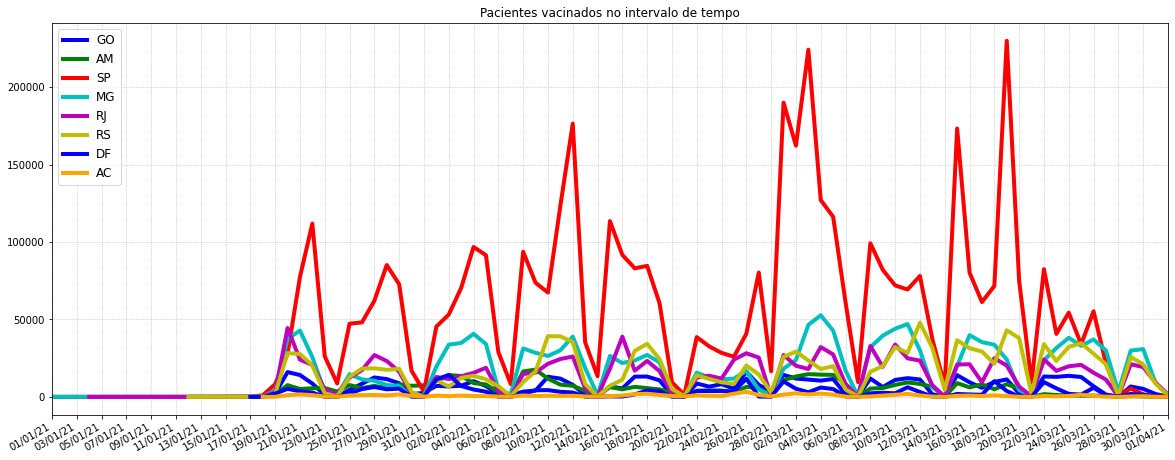

In [ ]:
#Plota doses aplicadas no intervalo de tempo (todos)
fig, ax = plt.subplots(figsize=(20,8))
#Cria intervalo de dias para eixo x
#Intervalo de datas do eixo definido com 2 dias
days = mdates.DayLocator(interval = 2)
#
#Atribui formato DD/MM/AA
d_fmt = mdates.DateFormatter('%d/%m/%y')
#Cria marcadores do eixo x
ax.xaxis.set_major_locator(days)
#Define limites do eixo x
ax.set_xlim([min(sp_doses['data_aplicacao']), max(sp_doses['data_aplicacao'])])
#Define formato dos marcadores
ax.xaxis.set_major_formatter(d_fmt)

#plota
ax.plot(go_doses.data_aplicacao, go_doses.vacinados, linewidth = 4, color = 'b', label='GO')
ax.plot(am_doses.data_aplicacao, am_doses.vacinados, linewidth = 4, color = 'g', label='AM')
ax.plot(sp_doses.data_aplicacao, sp_doses.vacinados, linewidth = 4, color = 'r', label='SP')

ax.plot(mg_doses.data_aplicacao, mg_doses.vacinados, linewidth = 4, color = 'c', label='MG')
ax.plot(rj_doses.data_aplicacao, rj_doses.vacinados, linewidth = 4, color = 'm', label='RJ')
ax.plot(rs_doses.data_aplicacao, rs_doses.vacinados, linewidth = 4, color = 'y', label='RS')

ax.plot(df_doses.data_aplicacao, df_doses.vacinados, linewidth = 4, color = 'b', label='DF')
ax.plot(ac_doses.data_aplicacao, ac_doses.vacinados, linewidth = 4, color = 'orange', label='AC')

ax.grid(linestyle=':', linewidth=0.7)
ax.title.set_text('Pacientes vacinados no intervalo de tempo')
ax.legend(fontsize=12, loc='upper left')
fig.autofmt_xdate()
plt.show();

In [ ]:
#Libera memória
del lat_null,
lon_null,
lat_null_agg,
lon_null_agg,
go,
am,
ds,
mg,
rj,
rs,
df,
ac,
go_doses,
am_doses,
mg_doses,
rj_doses,
rs_doses,
df_doses,
ac_doses
gc.collect;

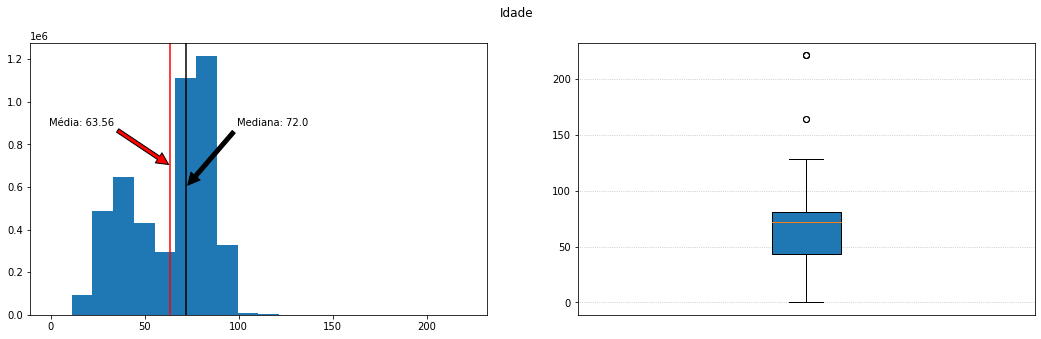

In [ ]:
#Plota distribuição das idades (SP)
fig, ax =  plt.subplots(nrows=1,ncols=2, figsize=(18,5))
fig.suptitle('Idade')

media = round(sp['idade_paciente'].mean(),2)
mediana = round(sp['idade_paciente'].median(),2)

ax[0].hist(sp['idade_paciente'], bins=20);
ax[0].axvline(media, c='red')
ax[0].axvline(mediana, c='black')
ax[0].annotate(('Média: %s' %media), 
              xy=(media, 700000), 
              xytext=(media-30, 900000),
           arrowprops=
                dict(facecolor='red', shrink=0.03),
                horizontalalignment='right',
                verticalalignment='center')

ax[0].annotate(('Mediana: %s' %mediana), 
              xy=(mediana, 600000), 
              xytext=(mediana+65, 900000),
           arrowprops=
                dict(facecolor='black', shrink=0.03),
                horizontalalignment='right',
                verticalalignment='center')
ax[1].boxplot(sp['idade_paciente'], patch_artist=True)
ax[1].grid(linestyle=':', linewidth=0.7)
ax[1].set_xticks([]) 
plt.show()

In [ ]:
#Separa registros com idade menor que 18
idade_menor = df.query(r"idade_paciente < 18")
#Separa registros com idade maior que 18
idade_maior = df.query(r"idade_paciente > 118")
print('Registros com idade menor que 18 :', idade_menor.shape[0])
print('Registros com idade maior que 118:', idade_maior.shape[0])
#Agrupa idades irregulares
idade_menor = (
    pd.DataFrame(idade_menor.groupby('idade_paciente')['id'].count())
    .reset_index()
    .rename(columns={'id':'quantidade'})
)

idade_maior = (
    pd.DataFrame(idade_maior.groupby('idade_paciente')['id'].count())
    .reset_index()
    .rename(columns={'id':'quantidade'})
)

Registros com idade menor que 18 : 2100
Registros com idade maior que 118: 3481


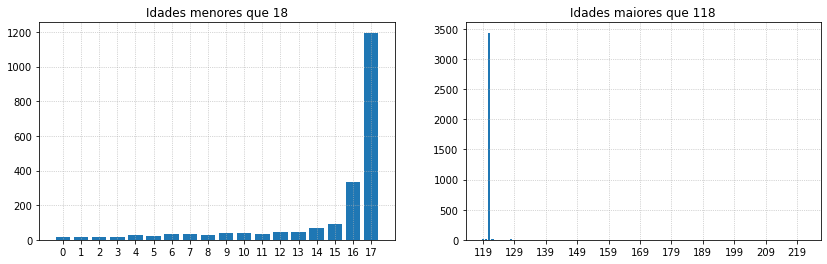

In [ ]:
#Visualiza
#define rotulos do eixo x para idades com base no intervalo
tamanho = np.arange(min(idade_maior['idade_paciente']),max(idade_maior['idade_paciente']),10)

fig, ax =  plt.subplots(nrows=1,ncols=2, figsize=(14,4))
#fig.suptitle('Idades irregulares')

ax[0].bar(idade_menor['idade_paciente'], idade_menor['quantidade'])
#Define intervalo dos rótulos
ax[0].set_xticks(idade_menor.idade_paciente.unique())
ax[0].set_title('Idades menores que 18')
ax[0].grid(linestyle=':', linewidth=0.7)
#
ax[1].bar(idade_maior['idade_paciente'], idade_maior['quantidade']);
ax[1].set_title('Idades maiores que 118')
ax[1].set_xticks(tamanho)
ax[1].grid(linestyle=':', linewidth=0.7)
plt.show()

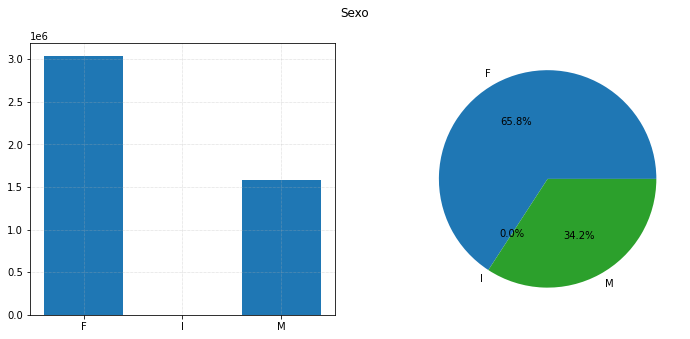

In [ ]:
#Agrupa sexo dos pacientes em SP
sex = (
    pd.DataFrame(sp.groupby('sexo')['id'].count())
    .reset_index()
    .rename(columns={'id':'quantidade'})
)

# Plota sexo dos pacientes
fig, ax =  plt.subplots(nrows=1,ncols=2, figsize=(12,5))
fig.suptitle('Sexo')
#
ax[0].bar(sex['sexo'],sex['quantidade'])
ax[0].grid(linestyle=':', linewidth=0.5)
ax[1].pie(sex['quantidade'], labels=(sex['sexo']),autopct='%1.1f%%')
plt.show()

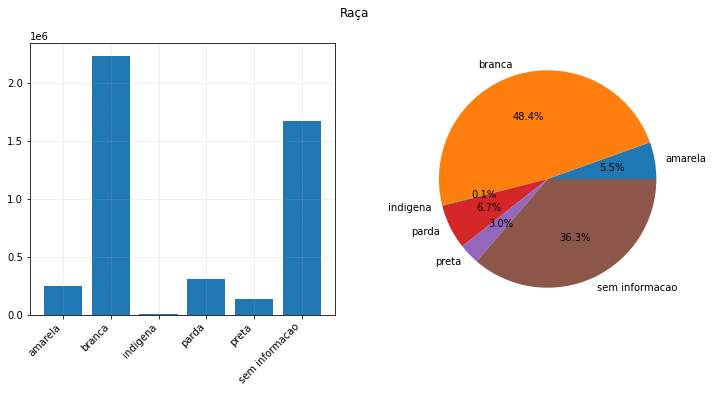

In [ ]:
raca_cor = (
    pd.DataFrame(sp.groupby('nm_raca_cor')['id'].count())
    .reset_index()
    .rename(columns={'id':'quantidade'})
)

# Plota raça dos pacientes
fig, ax =  plt.subplots(nrows=1,ncols=2, figsize=(12,5))
fig.suptitle('Raça')
#
ax[0].bar(raca_cor['nm_raca_cor'],raca_cor['quantidade'])
ax[0].grid(linestyle=':', linewidth=0.5)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
ax[1].pie(raca_cor['quantidade'], labels=(raca_cor['nm_raca_cor']),autopct='%1.1f%%')
plt.show()

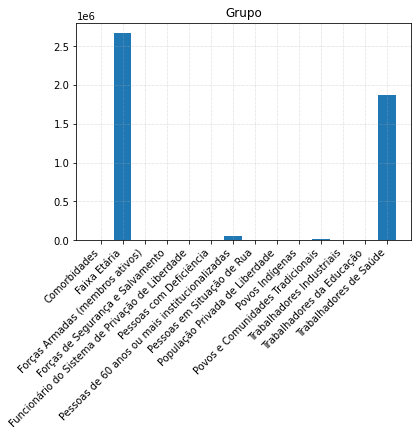

In [ ]:
grp = (
    pd.DataFrame(sp.groupby('grupo')['id'].count())
    .reset_index()
    .rename(columns={'id':'quantidade'})
)

plt.bar(grp['grupo'],grp['quantidade'])
plt.grid(linestyle=':', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.title('Grupo')
plt.show()

In [ ]:
#Libera memória
del media,
mediana,
idade_menor,
sex,
raca_cor,
grp
gc.collect;

Importa CSV dos casos de covid obtido em https://covid.saude.gov.br/

In [ ]:
hst = pd.read_csv(r'/content/drive/MyDrive/Softwares III/HIST_PAINEL_COVIDBR_11abr2021.csv',sep=';',encoding='utf-8',low_memory=False)

In [ ]:
#Dropa colunas não utilizadas
drop_casos = ['regiao', 'municipio', 'coduf',	'codRegiaoSaude', 'nomeRegiaoSaude', 'semanaEpi',	'casosAcumulado', 'obitosAcumulado', 'emAcompanhamentoNovos',	'interior/metropolitana']
hst = hst.drop(drop_casos, axis=1)

In [ ]:
#Agrupa vacinados casos por mun - A partir do base sp
vac = (
    pd.DataFrame(sp.groupby(['nm_municipio','cd_ibge_reduzido','lat','lon'])['id'].count())
    .reset_index()
    .rename(columns={'id':'vacinados'})
)

#Agrupa novos casos por mun
casos = (
    pd.DataFrame(hst.groupby('codmun')['casosNovos'].sum())
    .reset_index()
    .rename(columns={'casosNovos':'casos'})
)
#Agrupa novos obitos por mun
obitos = (
    pd.DataFrame(hst.groupby('codmun')['obitosNovos'].sum())
    .reset_index()
    .rename(columns={'obitosNovos':'obitos'})
)
#Agrupa média de população por mun
pop = (
    pd.DataFrame(hst.groupby('codmun')['populacaoTCU2019'].mean())
    .reset_index()
    .rename(columns={'populacaoTCU2019':'populacao'})
)

In [ ]:
#verifica nulos em pop
print(pop.isna().sum())

codmun        0
populacao    21
dtype: int64


In [ ]:
 #Atribui 0 para cidades registros cuja população = nan - Códigos com valor nulo são dos estados
pop['populacao'].fillna(0, inplace=True)
#Transforma cod mun em inteiro
casos['codmun'] = casos['codmun'].astype(int)
obitos['codmun'] = obitos['codmun'].astype(int)
pop['codmun'] = pop['codmun'].astype(int)
#Transforma população em inteiro
pop['populacao'] = pop['populacao'].astype(int)

In [ ]:
#Valida se todas as 645 cidade de SP estão no arquivo
print('Quantidade de linhas:', vac.shape[0])
vac.sort_values('cd_ibge_reduzido').head(5)

Quantidade de linhas: 645


nm_municipio  cd_ibge_reduzido        lat        lon  vacinados
0          Adamantina            350010 -21.682483 -51.074171       5744
1              Adolfo            350020 -21.234655 -49.643065        664
2               Aguaí            350030 -22.057724 -46.973950       3154
637    Águas da Prata            350040 -21.946969 -46.718586       1560
638  Águas de Lindóia            350050 -22.480360 -46.633882       1815

Merges dos dados de casos de covid, óbitos e população obtidos no site coronavirus brasil, com os dados obtidos na base

In [ ]:
#Merge com dados de casos
sp_vac = pd.merge(vac, casos, left_on='cd_ibge_reduzido', right_on='codmun')
#Dropa coluna codmun pois já existe similar
sp_vac = sp_vac.drop('codmun', axis=1)
#Merge com dados de obitos
sp_vac = pd.merge(sp_vac, obitos, left_on='cd_ibge_reduzido', right_on='codmun')
#Dropa coluna codmun pois já existe similar
sp_vac = sp_vac.drop('codmun', axis=1)
#Merge com dados de população
sp_vac = pd.merge(sp_vac, pop, left_on='cd_ibge_reduzido', right_on='codmun')
#Dropa coluna codmun pois já existe similar
sp_vac = sp_vac.drop('codmun', axis=1)

In [ ]:
#Plota População
#Define limites do estado de SP
limites = (r'/content/drive/MyDrive/Softwares III/sp_1.geojson')
mapa_sp = json.load(open(limites))
#-

#Ordena dataframe pela quantidade para obter o 4 maiores
sp_vac = sp_vac.sort_values('populacao',ascending=False)
#
#Cria mapa
pop_map = folium.Map(location=[-22.5,-49],zoom_start=7)
folium.GeoJson(mapa_sp).add_to(pop_map)
#
borda = ''
for i, row in sp_vac.iterrows():
#    
    if i < 3:
        borda = 'red'
    elif i < 6:
        borda = 'yellow'
    else:
        borda = '#3186cc'
#        
    folium.CircleMarker(
    location=[sp_vac.iloc[i,2], sp_vac.iloc[i,3]],
    radius=(sp_vac.iloc[i,7]*0.00001),
    popup=(sp_vac.iloc[i,0] + ": " + str(sp_vac.iloc[i,7])),
    color=borda,
    fill=True,
    fill_color="#3186cc",
).add_to(pop_map)
#-----------------------------------------------------------
#Monta título
title = 'População'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(title)   
pop_map.get_root().html.add_child(folium.Element(title_html))
#-----------------------------------------------------------
pop_map

In [ ]:
#Plota Casos
#Ordena dataframe pela quantidade para obter os maiores e mudar a cor
sp_vac = sp_vac.sort_values('casos',ascending=False)
#
#Cria mapa
casos_map = folium.Map(location=[-22.5,-49],zoom_start=7)
folium.GeoJson(mapa_sp).add_to(casos_map)
#
borda = ''
for i, row in sp_vac.iterrows():
#    
    if i < 3:
        borda = 'red'
    elif i < 6:
        borda = 'yellow'
    else:
        borda = '#3186cc'
#        
    folium.CircleMarker(
    location=[sp_vac.iloc[i,2], sp_vac.iloc[i,3]],
    radius=(sp_vac.iloc[i,5]*0.0001),
    popup=(sp_vac.iloc[i,0] + ": " + str(sp_vac.iloc[i,5])),
    color=borda,
    fill=True,
    fill_color="#3186cc",
).add_to(casos_map)
#-----------------------------------------------------------
#Monta título
title = 'Casos'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(title)   
casos_map.get_root().html.add_child(folium.Element(title_html))
#-----------------------------------------------------------
casos_map

In [ ]:
#Plota Óbitos
#Retira óbitos = 0
sp_vac_obts = sp_vac.query(r"obitos > 0").reset_index(drop=True)
#Ordena dataframe pela quantidade para obter os maiores e mudar a cor
sp_vac_obts = sp_vac_obts.sort_values('obitos',ascending=False)
#
#Cria mapa
obitos_map = folium.Map(location=[-22.5,-49],zoom_start=7)
folium.GeoJson(mapa_sp).add_to(obitos_map)
#
borda = ''
for i, row in sp_vac_obts.iterrows():
#    
    if i < 3:
        borda = 'red'
    elif i < 6:
        borda = 'yellow'
    else:
        borda = '#3186cc'
#        
    folium.CircleMarker(
    location=[sp_vac_obts.iloc[i,2], sp_vac_obts.iloc[i,3]],
    radius=(sp_vac_obts.iloc[i,6]*0.001),
    popup=(sp_vac_obts.iloc[i,0] + ": " + str(sp_vac_obts.iloc[i,6])),
    color=borda,
    fill=True,
    fill_color="#3186cc",   
).add_to(obitos_map)
#-----------------------------------------------------------
#Monta título
title = 'Óbitos'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(title)   
obitos_map.get_root().html.add_child(folium.Element(title_html))
#-----------------------------------------------------------
obitos_map

In [ ]:
#Plota os maiores
#5 maiores populações do estado
pop_maior = sp_vac.sort_values('populacao',ascending=False).reset_index(drop=True).head(5)
#5 cidades com maior número de vacinados
vac_maior = sp_vac.sort_values('vacinados',ascending=False).reset_index(drop=True).head(5)
#5 cidades com maior número de casos
casos_maior = sp_vac.sort_values('casos',ascending=False).reset_index(drop=True).head(5)
#5 cidades com maior número de óbitos
obitos_maior = sp_vac.sort_values('obitos',ascending=False).reset_index(drop=True).head(5)
#
#Cria mapa
maiores_map = folium.Map(location=[-23.5,-46],zoom_start=7)
#limites = folium.GeoJson(mapa_sp)
limites = folium.GeoJson(data = mapa_sp, name='<span style=\\"color: #3186cc;\\">Limites</span>')
#
limites.add_to(maiores_map)

pop_mark = folium.FeatureGroup(name='<span style=\\"color: red;\\">População</span>')
for i, row in pop_maior.iterrows():        
    folium.CircleMarker(
    location=[pop_maior.iloc[i,2], pop_maior.iloc[i,3]],
    radius=(pop_maior.iloc[i,7]*0.00001),
    popup=(pop_maior.iloc[i,0] + ": " + str(pop_maior.iloc[i,7])),
    color='red',
    fill=False,
    ).add_to(pop_mark)
pop_mark.add_to(maiores_map)
#
casos_mark = folium.FeatureGroup(name='<span style=\\"color: green;\\">Casos</span>')
for i, row in casos_maior.iterrows():        
    folium.CircleMarker(
    location=[casos_maior.iloc[i,2], casos_maior.iloc[i,3]],
    radius=(casos_maior.iloc[i,5]*0.0001),
    popup=(casos_maior.iloc[i,0] + ": " + str(casos_maior.iloc[i,5])),
    color='green',
    fill=False,
    ).add_to(casos_mark)
casos_mark.add_to(maiores_map)
#
obitos_mark = folium.FeatureGroup(name='<span style=\\"color: orange;\\">Óbitos</span>')
for i, row in obitos_maior.iterrows():        
    folium.CircleMarker(
    location=[obitos_maior.iloc[i,2], obitos_maior.iloc[i,3]],
    radius=(obitos_maior.iloc[i,6]*0.001),
    popup=(obitos_maior.iloc[i,0] + ": " + str(obitos_maior.iloc[i,6])),
    color='orange',
    fill=False,
    ).add_to(obitos_mark)
obitos_mark.add_to(maiores_map)
#
vac_mark = folium.FeatureGroup(name='<span style=\\"color: black;\\">Vacinados</span>')
for i, row in vac_maior.iterrows():        
    folium.CircleMarker(
    location=[vac_maior.iloc[i,2], vac_maior.iloc[i,3]],
    radius=(vac_maior.iloc[i,4]*0.0001),
    popup=(vac_maior.iloc[i,0] + ": " + str(vac_maior.iloc[i,4])),
    color='black',
    fill=False,
    ).add_to(vac_mark)
vac_mark.add_to(maiores_map)


folium.map.LayerControl('topleft', collapsed=False).add_to(maiores_map)

maiores_map

In [ ]:
#Cria novos dataframes agrupando por data e estado
hst_sp = hst.query(r"estado == 'SP'")
#Dropa casos sem codmun
hst_sp = hst_sp.dropna(subset=['codmun'])
#Transforma codmum em int
hst_sp['codmun'] = hst_sp['codmun'].astype(int)
#Retira codmum igual a 350000 - estado de SP
hst_sp = hst_sp.query(r"codmun > 350000")
#reseta indice
hst_sp = hst_sp.reset_index(drop=True)
#print(hst_sp.isna().sum())
hst_sp.head(5)
#***************************************************************
#Quantidade de pacientes vacinados por data
vacinados_data_sp = (
    pd.DataFrame(sp.groupby(['data_aplicacao'])['id'].count())
    .reset_index()
    .rename(columns={'id':'vacinados'})
)

#Agrupa casos por data - soma casos novo por data
casos_data_sp = (
    pd.DataFrame(hst_sp.groupby('data')['casosNovos'].sum())
    .reset_index()
    .rename(columns={'casosNovos':'casos'})
)
#
#Agrupa óbitos por data - soma óbitos novos por data
obitos_data_sp = (
    pd.DataFrame(hst_sp.groupby('data')['obitosNovos'].sum())
    .reset_index()
    .rename(columns={'obitosNovos':'obitos'})
)
#Cria colunas nos respectivos dataframes com as médias dos últimos 7 dias
#Vacinados
vacinados_data_sp['media_semanal'] = (vacinados_data_sp['vacinados'].rolling(7, min_periods=1).mean())
#Casos
casos_data_sp['media_semanal'] = (casos_data_sp['casos'].rolling(7, min_periods=1).mean())
#Óbitos
obitos_data_sp['media_semanal'] = (obitos_data_sp['obitos'].rolling(7, min_periods=1).mean())
#**********************************************************************************************
#Transforma as strings datas em date, reordena por data e reseta o índice 
#Vacinados
vacinados_data_sp['data_aplicacao'] =  pd.to_datetime(vacinados_data_sp['data_aplicacao'])
vacinados_data_sp = vacinados_data_sp.sort_values('data_aplicacao').reset_index(drop=True)
#Casos
casos_data_sp['data'] =  pd.to_datetime(casos_data_sp['data'])
casos_data_sp = casos_data_sp.sort_values('data').reset_index(drop=True)
#Óbitos
obitos_data_sp['data'] =  pd.to_datetime(obitos_data_sp['data'])
obitos_data_sp = obitos_data_sp.sort_values('data').reset_index(drop=True)

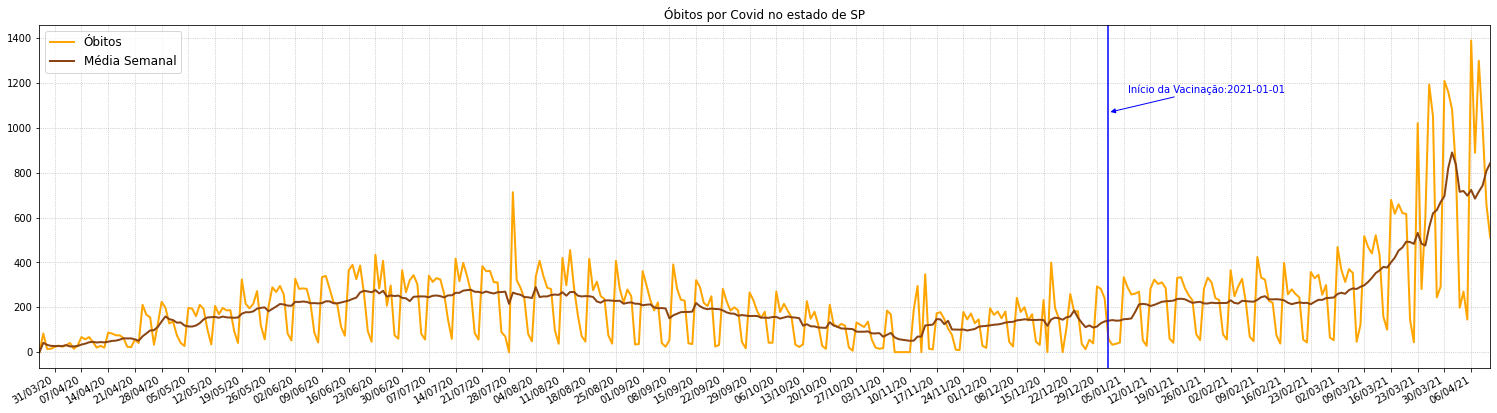

In [ ]:
#Plota óbitos e média semanal
fig, ax = plt.subplots(figsize=(26,7))
#Cria marcadores do eixo x
days = mdates.DayLocator(interval = 7)
#
ax.xaxis.set_major_locator(days)
#Define formato dos marcadores
ax.xaxis.set_major_formatter(d_fmt)

#Define limites do eixo x
ax.set_xlim([min(obitos_data_sp['data']), max(obitos_data_sp['data'])])
#plota
ax.plot(obitos_data_sp.data, obitos_data_sp.obitos, linewidth = 2, color='orange', label='Óbitos')
ax.plot(obitos_data_sp.data, obitos_data_sp.media_semanal, linewidth = 2, color='saddlebrown', label='Média Semanal')
ax.grid(linestyle=':', linewidth=0.7)
## Tranforma data início de vacinação em número para anotar
inic_vac = mdates.date2num(min(vacinados_data_sp.data_aplicacao))
ax.legend(fontsize=12, loc='upper left')
ax.axvline(inic_vac, c='blue')
ax.annotate('Início da Vacinação:%s' %str(min(vacinados_data_sp.data_aplicacao))[0:10], (inic_vac, (max(obitos_data_sp.obitos)/1.3)), xytext=(20, 20), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>',color='blue'),color='blue')
##
ax.title.set_text('Óbitos por Covid no estado de SP')

fig.autofmt_xdate()
plt.show();

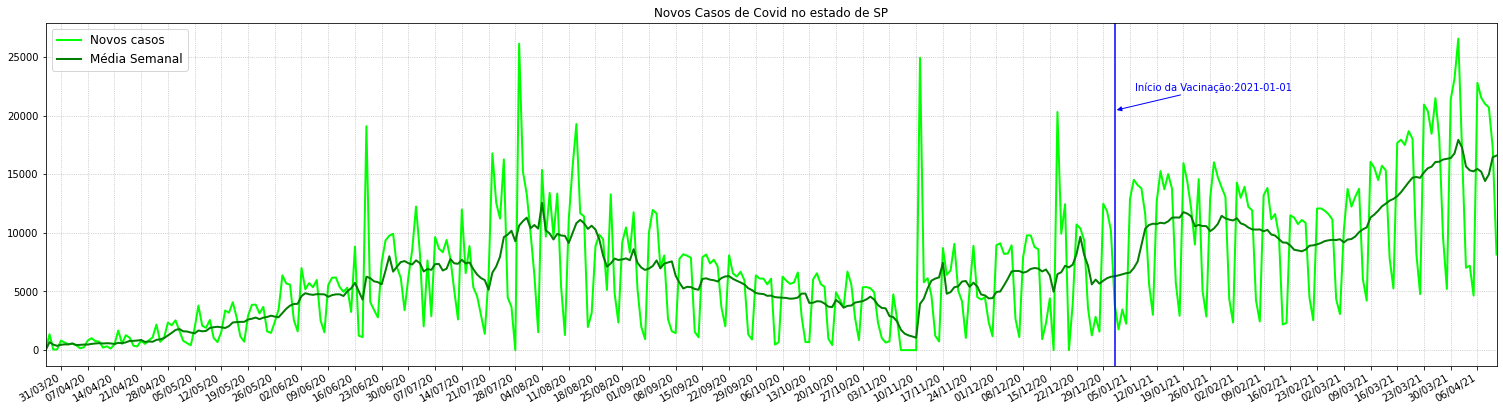

In [ ]:
#Plota novos casos no intervalo de tempo
fig, ax = plt.subplots(figsize=(26,7))
#Cria marcadores do eixo x
days = mdates.DayLocator(interval = 7)
#
ax.xaxis.set_major_locator(days)
#Define formato dos marcadores
ax.xaxis.set_major_formatter(d_fmt)

#Define limites do eixo x
ax.set_xlim([min(obitos_data_sp['data']), max(obitos_data_sp['data'])])
#plota
ax.plot(casos_data_sp.data, casos_data_sp.casos, linewidth = 2, color='lime', label='Novos casos')
ax.plot(casos_data_sp.data, casos_data_sp.media_semanal, linewidth = 2, color='green', label='Média Semanal')
ax.grid(linestyle=':', linewidth=0.7)
## Tranforma data início de vacinação em número para anotar início da vacinação
inic_vac = mdates.date2num(min(vacinados_data_sp.data_aplicacao))
ax.legend(fontsize=12, loc='upper left')
ax.axvline(inic_vac, c='blue')
ax.annotate('Início da Vacinação:%s' %str(min(vacinados_data_sp.data_aplicacao))[0:10], (inic_vac, (max(casos_data_sp.casos)/1.3)), xytext=(20, 20), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>',color='blue'),color='blue')
##
ax.title.set_text('Novos Casos de Covid no estado de SP')

fig.autofmt_xdate()
plt.show();

In [ ]:
#Verifica estados disponíveis
ufs()

array(['SP', 'RJ', 'GO', 'RS', 'AC', 'MG', 'AM', 'DF'], dtype=object)

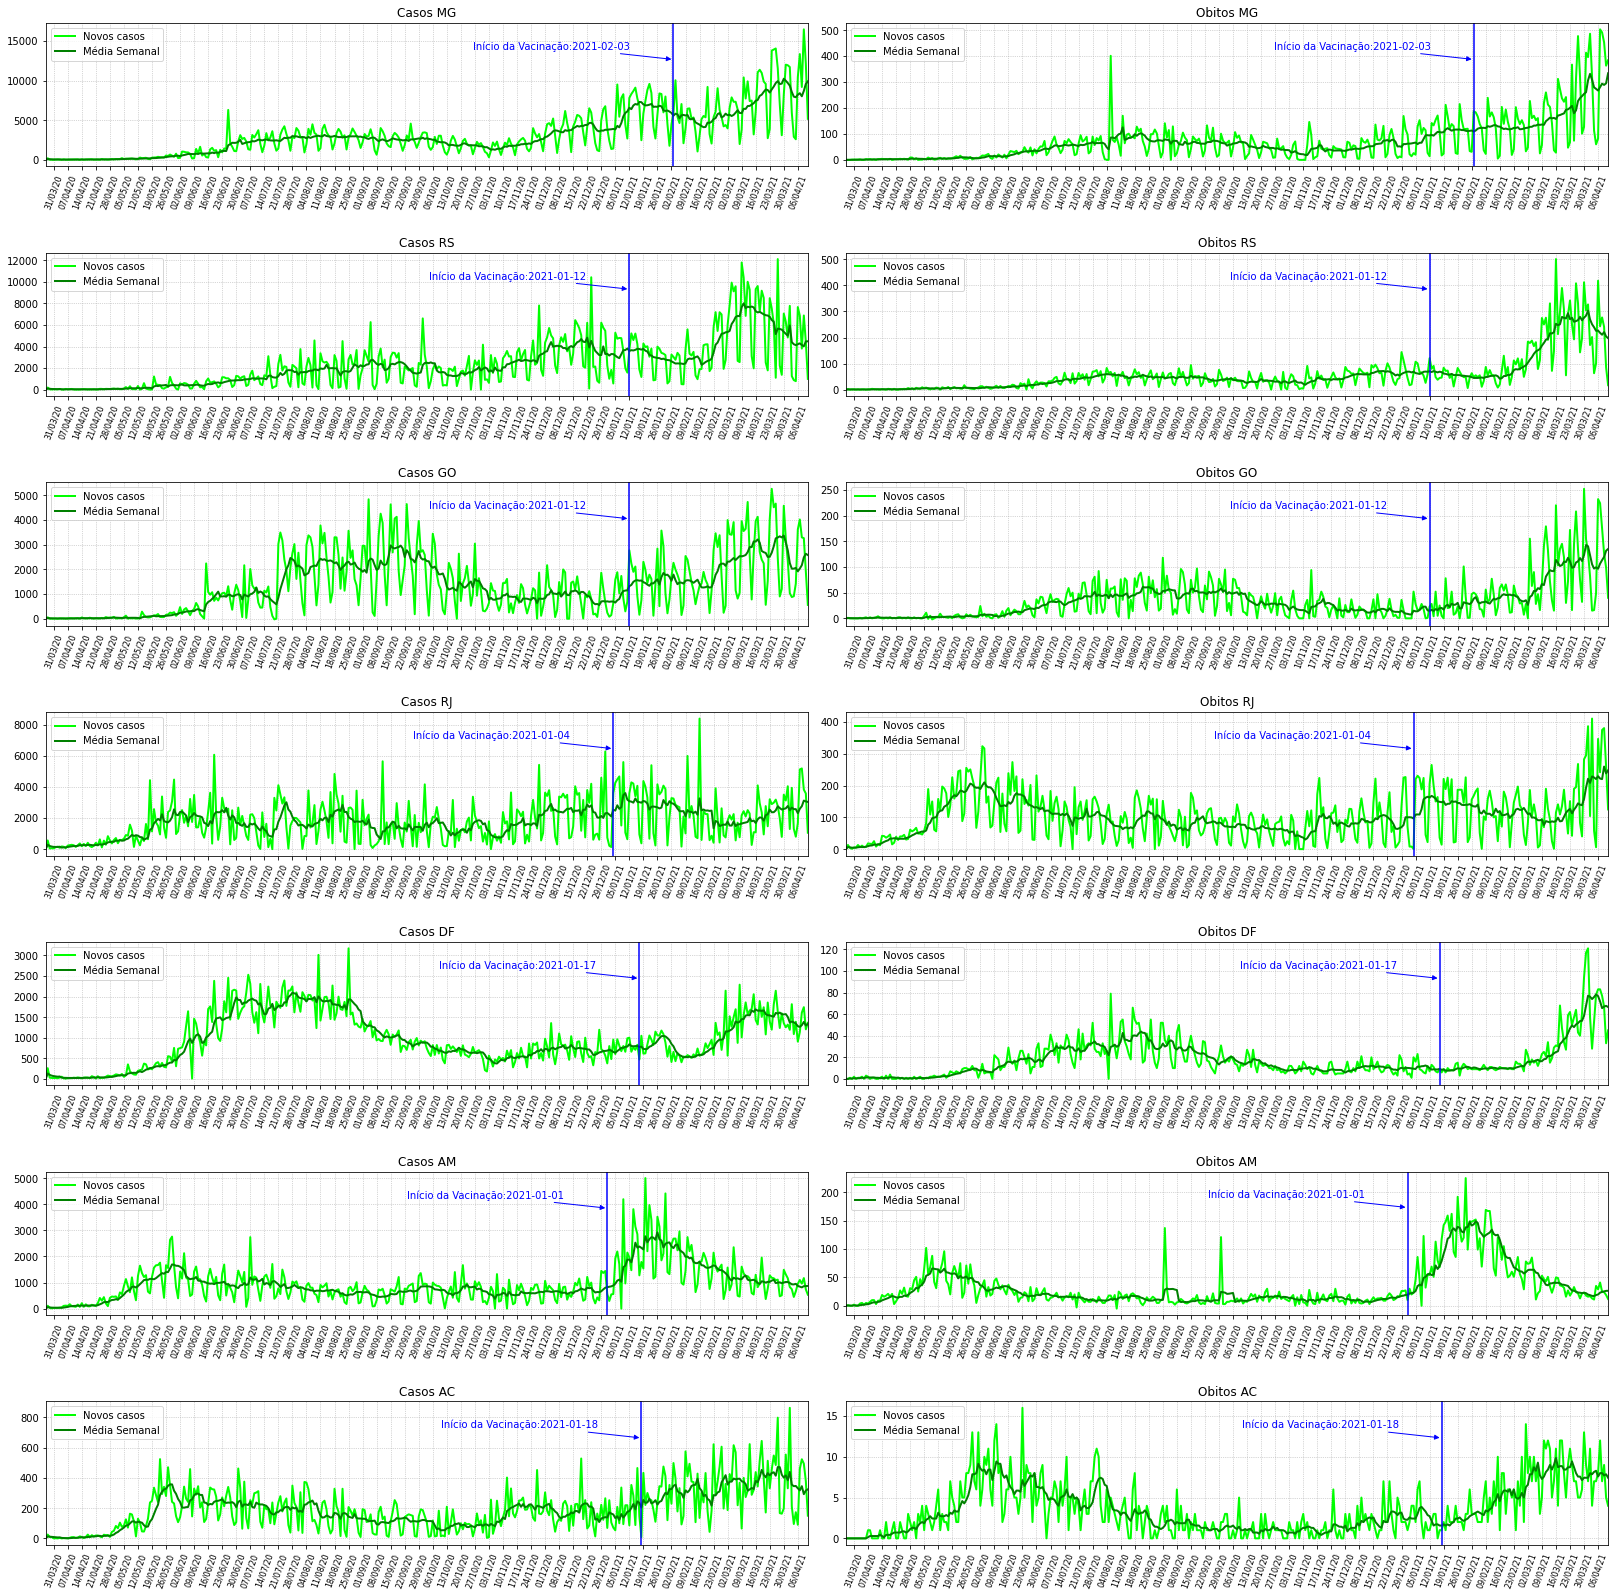

In [ ]:
#Cria novos dataframes agrupando por data e estado
#
#Define intervalo de dias do eixo x
days = mdates.DayLocator(interval = 7)
#

dataframes_estados = []
lista_estados = ['mg','rs','go','rj','df','am','ac'] #Somente estados disponíveis em ufs()
for estado in lista_estados:
    #Busca dados a serem plotados
    str_nm_est = ('hst_'+ estado)
    query = ("estado == '%s'" %estado.upper())
    str_nm_est = hst.query(query)
    str_nm_est = str_nm_est.dropna(subset=['codmun'])
    str_nm_est['codmun'] = str_nm_est['codmun'].astype(int)
    if estado != 'df':
        if min(str_nm_est['codmun'])%10 == 0:       #se o menor valor do codmun for código do estado, remove do dataframe
            str_cod_mun_est = ("codmun > %i" %min(str_nm_est['codmun']))    
            str_nm_est = str_nm_est.query(str_cod_mun_est)
        str_nm_est = str_nm_est.reset_index(drop=True)
    dataframes_estados.append(str_nm_est)
  #
tipos = ['casos', 'obitos']
colunas = ['casosNovos','obitosNovos']
aggs = {}
for i in range(len(dataframes_estados)):
    for z, tipo in enumerate(tipos):
        nome_dataframe = (tipo+'_data_'+lista_estados[i])
        aggs[nome_dataframe] =(
            pd.DataFrame(dataframes_estados[i].groupby('data')[colunas[z]].sum())
            .sort_values('data')
            .reset_index()
            .rename(columns={colunas[z]:'quantidade'})                    )
##-------------------------------------------------------------------------------------------
for dataframe in aggs:
    aggs[dataframe]['media_semanal'] = (aggs[dataframe].iloc[:,1].rolling(7, min_periods=1).mean())
    aggs[dataframe]['data'] =  pd.to_datetime(aggs[dataframe].data)
    aggs[dataframe]['quantidade'] = aggs[dataframe]['quantidade']
    aggs[dataframe] = aggs[dataframe].sort_values('data').reset_index(drop=True)
##-------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(28, (4*(len(aggs)/2)))) #Determina o tamnaho da figura com base na quantidade de estados
plt.subplots_adjust(wspace= 0.05, hspace= 0.6)
for i, key in enumerate(aggs.keys()):
    #Define título do gráfico
    tit = key.split('_')[0].capitalize() + ' ' + key.split('_')[2].upper()
    #
    nome_plot = fig.add_subplot((len(aggs)/2),2,(i+1)) #Quantidade de plots (x,y,z) Qtd linhas, qtd colunas, célula a construir
    ax = plt.gca()
    ax.xaxis.set_major_formatter(d_fmt)
    ax.xaxis.set_major_locator(days)
    ax.set_xlim([min(aggs[key].data), max(aggs[key].data)])
    plt.plot(aggs[key].data, aggs[key].quantidade, linewidth = 2, color='lime', label='Novos casos')
    plt.plot(aggs[key].data, aggs[key].media_semanal,linewidth = 2, color='green', label='Média Semanal')
    plt.xticks(rotation = (70), fontsize = 8, ha='center')
    plt.grid(linestyle=':', linewidth=0.7)
  #
  #Define a data da primeira vacina
    query_data_vac = ("uf == '%s'" %key.split('_')[2].upper()) #String que será a query para buscar a data da primeira vacina no estado)
    date_line = min(df.query(query_data_vac).data_aplicacao) #Define a data da vacina (Busca a data no dataframe)
    #Tratamento de ano menor que 2021 - Se ano menor que 2021 força 2021
    if date_line.year < 2020:
        date_line = date_line.replace(year=2021)
  #
    date_line_pos = mdates.date2num(date_line) #Transforma data da vacina em int
  #
    plt.axvline(date_line_pos, c='blue') #Linha do início da vacinação
  #
    ax.annotate('Início da Vacinação:%s' %date_line, (date_line_pos, (max(aggs[key].quantidade)/1.3)), xytext=(-200, 10), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>',color='blue'),color='blue')
  #
    plt.legend(loc='upper left')
    plt.title(tit)
plt.show();